In [1]:
import glob
import os
import cv2
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from openslide import OpenSlide
import h5py
from omegaconf import OmegaConf
from matplotlib import patches
from PIL import Image
import json
from shapely import Polygon
from shapely.plotting import plot_polygon
from shapely.geometry import mapping
from shapely.geometry import box
from shapely.geometry import Polygon
from rtree import index
from collections import Counter
from tqdm import tqdm

In [2]:
conf_preproc = OmegaConf.load("../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["jmcs_224_224_patches"]

### Number of regions in the NG cohort

WSIs: 574 patients: 9489 

### WSI

In [3]:
final_df = pd.read_csv("../cv_splits_paper/cv_splits_multi_stratified_sklearn_s_a_r_mo_paper_patients_rev/final_df_with_excluded_slides_cluster_tsne_1_2_3.csv")
final_df["Pathological"] = final_df["Pathological"].astype(int)

In [4]:
final_df.shape

(574, 13)

In [ ]:
final_df.head(5)

In [6]:
np.array([len(ast.literal_eval(c)) for c in final_df['slide_id'].values]).sum()

9489

In [7]:
slides = np.array((
    final_df["slide_id"]
      .map(ast.literal_eval)   # string -> list
      .explode()               # one slide per row
      .dropna()
      .tolist()
))

In [8]:
len(slides), len(set(slides))

(9489, 9489)

In [9]:
slides[:3]

array(['043c1fec-f4ab-4187-8814-a879d856f1ab',
       '05978312-1562-4c25-be85-9425def7be13',
       '0bf7743f-c788-4b83-9b9b-d583193fc7db'], dtype='<U36')

In [10]:
def load_h5_file(filename):
    with h5py.File(filename, "r") as f:
        coords = f['coords'][()]
        patch_level = f['coords'].attrs['patch_level']
        patch_size = f['coords'].attrs['patch_size']
        return coords, patch_level, patch_size

In [11]:
coords, patch_level, patch_size = load_h5_file(conf_preproc.mask_dir_improved_v2 + "00046960-74ec-4750-b972-c4bf78eb40d6.h5")

In [12]:
coords.shape, patch_level, patch_size

((34, 2), 4, 224)

In [13]:
num_regions = []

for i in tqdm(range(slides.shape[0])):

    coords, _, _ = load_h5_file(conf_preproc.mask_dir_improved_v2 + slides[i] + ".h5")

    num_regions.append(coords.shape[0])

num_regions = np.array(num_regions)

100%|██████████| 9489/9489 [01:15<00:00, 126.44it/s]


In [14]:
print("Number of 224x224 regions:", num_regions.sum())

Number of 224x224 regions: 2058794


In [15]:
num_regions.mean()

216.96638212667298

### Patients

In [16]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [17]:
features, _, _, _ = load_h5_file_biopsy_bag(conf_preproc.uni_finetuned_biopsy_dir_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev + 
                                                         "005fbcaa-cecc-4f57-8f83-3a3acafcdd30.h5")
features.shape

(17170, 1024)

In [18]:
biopsy_bags = np.sort(np.array( glob.glob( os.path.join(conf_preproc.uni_finetuned_biopsy_dir_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev, "*.h5")) ))

In [19]:
biopsy_bags.shape

(574,)

In [20]:
num_regions_patients = []

for i in tqdm(range(biopsy_bags.shape[0])):

    features, _, _, _ = load_h5_file_biopsy_bag(conf_preproc.uni_finetuned_biopsy_dir_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev + os.path.basename(biopsy_bags[i]))

    num_regions_patients.append(features.shape[0])

num_regions_patients = np.array(num_regions_patients)

100%|██████████| 574/574 [00:42<00:00, 13.40it/s]


In [21]:
num_regions_patients.sum()

2058794

### Summary table

In [22]:
# -----------------------------
# INPUTS you already have:
# - final_df: 574 rows, unique patient id column = "patient_ngsci_id"
# - final_df["slide_id"]: string representation of list of slide UUIDs
# - slides: np.array length 9489 (order matches your num_regions construction)
# - num_regions: np.array length 9489 (patch counts per slide in 'slides' order)
# -----------------------------

# 0) Basic checks
assert "patient_ngsci_id" in final_df.columns, "final_df must contain patient_ngsci_id"
assert "slide_id" in final_df.columns, "final_df must contain slide_id"
assert len(slides) == len(num_regions), "slides and num_regions must be the same length"

# 1) Build WSI-level dataframe with columns: patient_ngsci_id, slide_id
#    This is the NG equivalent of Semmelweis labels_df
labels_ng = (
    final_df[["patient_ngsci_id", "slide_id"]]
    .assign(slide_id=final_df["slide_id"].map(ast.literal_eval))
    .explode("slide_id")
    .dropna(subset=["slide_id"])
    .reset_index(drop=True)
)

# 2) Attach patch counts to each slide (robust approach: merge by slide_id)
#    This avoids relying on ordering assumptions.
patch_df = pd.DataFrame({
    "slide_id": slides.astype(str),
    "n_patches_wsi": np.asarray(num_regions).astype(int),
})

# Safety: ensure slide_id uniqueness in patch_df (should be unique; if not, aggregate)
if patch_df["slide_id"].duplicated().any():
    patch_df = patch_df.groupby("slide_id", as_index=False)["n_patches_wsi"].sum()

labels_ng = labels_ng.merge(patch_df, on="slide_id", how="left")

# Sanity checks: missing patch counts?
n_missing = labels_ng["n_patches_wsi"].isna().sum()
if n_missing > 0:
    # You can choose to error out instead; I default to raising because missingness
    # will bias medians/totals.
    missing_examples = labels_ng.loc[labels_ng["n_patches_wsi"].isna(), "slide_id"].head(10).tolist()
    raise ValueError(
        f"{n_missing} slides in labels_ng have no patch counts after merge. "
        f"Examples: {missing_examples}. "
        "This typically means a mismatch between slide_id strings and your H5 filenames."
    )

# 3) Helper to compute median [IQR] and min–max
def median_iqr_minmax(x):
    x = np.asarray(x)
    q1, med, q3 = np.percentile(x, [25, 50, 75])
    return {
        "median": float(med),
        "q1": float(q1),
        "q3": float(q3),
        "min": int(np.min(x)),
        "max": int(np.max(x)),
        "median_iqr_str": f"{med:.0f} [{q1:.0f}, {q3:.0f}]",
        "minmax_str": f"{int(np.min(x))}–{int(np.max(x))}",
    }

# -----------------------------
# A) PATCHES PER WSI
# -----------------------------
wsi_stats = median_iqr_minmax(labels_ng["n_patches_wsi"].values)

# -----------------------------
# B/C) PATIENT-LEVEL AGGREGATION
# - patches per patient: sum across patient's WSIs
# - WSIs per patient: count
# -----------------------------
per_patient = (
    labels_ng
    .groupby("patient_ngsci_id", as_index=False)
    .agg(
        n_patches_patient=("n_patches_wsi", "sum"),
        n_wsis=("slide_id", "count"),
    )
)

patient_patch_stats = median_iqr_minmax(per_patient["n_patches_patient"].values)
wsis_per_patient_stats = median_iqr_minmax(per_patient["n_wsis"].values)

# -----------------------------
# D) TOTALS
# -----------------------------
total_patches = int(labels_ng["n_patches_wsi"].sum())
n_wsis = int(labels_ng["slide_id"].nunique())
n_patients = int(labels_ng["patient_ngsci_id"].nunique())

# 4) Final 1-row cohort summary table (NG)
summary_ng = pd.DataFrame([{
    "Cohort": "Nightingale",
    "Patients (n)": n_patients,
    "WSIs (n)": n_wsis,
    "WSIs/patient, median [IQR]": wsis_per_patient_stats["median_iqr_str"],
    "WSIs/patient, min–max": wsis_per_patient_stats["minmax_str"],
    "Patches/WSI, median [IQR]": wsi_stats["median_iqr_str"],
    "Patches/WSI, min–max": wsi_stats["minmax_str"],
    "Patches/patient, median [IQR]": patient_patch_stats["median_iqr_str"],
    "Patches/patient, min–max": patient_patch_stats["minmax_str"],
    "Total patches (2.5x)": total_patches,
}])

summary_ng


,Cohort,Patients (n),WSIs (n),"WSIs/patient, median [IQR]","WSIs/patient, min–max","Patches/WSI, median [IQR]","Patches/WSI, min–max","Patches/patient, median [IQR]","Patches/patient, min–max",Total patches (2.5x)
0,Nightingale,574,9489,"11 [5, 24]",1–110,"193 [100, 312]",1–819,"1228 [458, 5812]",46–28286,2058794


In [23]:
summary_ng.to_csv("summary_ng.csv", index=False)

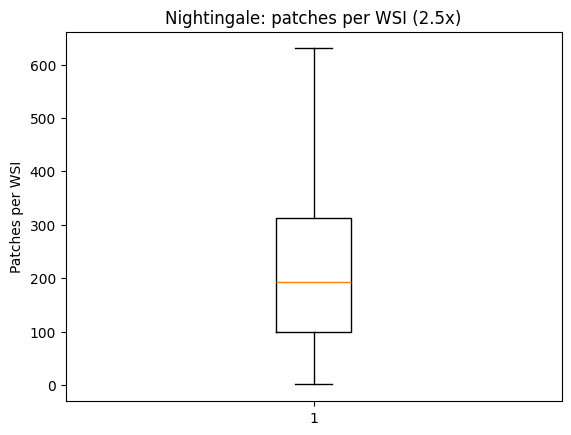

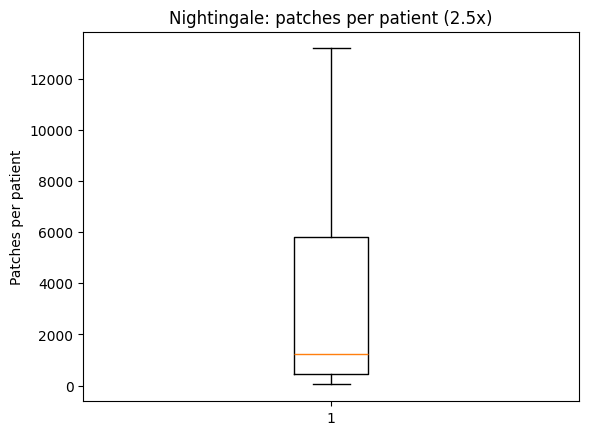

In [24]:
plt.figure()
plt.boxplot(labels_ng["n_patches_wsi"].values, showfliers=False)
plt.ylabel("Patches per WSI")
plt.title("Nightingale: patches per WSI (2.5x)")
plt.show()

plt.figure()
plt.boxplot(per_patient["n_patches_patient"].values, showfliers=False)
plt.ylabel("Patches per patient")
plt.title("Nightingale: patches per patient (2.5x)")
plt.show()
